In [0]:
#Init
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense,Conv2D,Conv2DTranspose,Input,Flatten,Lambda,Reshape
from keras.models import Model,Sequential

Using TensorFlow backend.


In [0]:
#Dataset
mnist = keras.datasets.mnist
(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.astype("float32")/255

In [0]:
#Sampling fn
def sampling(args):
  mean,log_std=args
  batch = keras.backend.shape(mean)[0]
  dim = keras.backend.int_shape(mean)[1]
  epsilon = keras.backend.random_normal(shape=(batch,dim))
  return (mean + keras.backend.exp(0.5*log_std)*epsilon)

In [0]:
#Encoder
input_shape = train_images.shape
print(input_shape)
x = Input(input_shape[1:])
x1 = Conv2D(32,4,activation="relu")(x)
x2 = Conv2D(32,4,activation="relu")(x1)
x3 = Conv2D(32,4,activation="relu")(x2)
x4 = Conv2D(32,4,activation="relu")(x3)
x5 = Flatten()(x4)
x6 = Dense(32,activation="relu")(x5)
z_mean = Dense(2)(x6)
z_log_std = Dense(2)(x6)
z = Lambda(sampling,output_shape=(2,))([z_mean,z_log_std])
encoder = Model(x,[z_mean,z_log_std,z])
encoder.summary()
#z_mean = Conv2D(2,)

(60000, 28, 28, 1)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 25, 25, 32)   544         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 22, 22, 32)   16416       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 19, 19, 32)   16416       conv2d_11[0][0]                  
_________________________________________________________________________

In [0]:
encoder.compile(optimizer="adam",loss="mse")

In [0]:
encoder.predict(train_images[3].reshape(1,28,28,1))

[array([[ 0.07272054, -0.00170924]], dtype=float32),
 array([[-0.01178361, -0.00767422]], dtype=float32),
 array([[0.26744366, 0.63542515]], dtype=float32)]

In [0]:
#Decoder
z1 = Input(shape=(2,))
d0 = Dense(32,activation="relu")(z1)
p = Dense(8192,activation="relu")(d0)
d = Reshape((16, 16, 32))(p)
d1 = Conv2DTranspose(32,4,activation="relu")(d)
d2 = Conv2DTranspose(32,4,activation="relu")(d1)
d3 = Conv2DTranspose(32,4,activation="relu")(d2)
out = Conv2DTranspose(1,4,activation="sigmoid")(d3)
decoder = Model(z1,out)

In [0]:
decoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_19 (Dense)             (None, 8192)              270336    
_________________________________________________________________
reshape_5 (Reshape)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 19, 19, 32)        16416     
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 22, 22, 32)        16416     
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 25, 25, 32)        1641

In [0]:
out = decoder(encoder(x)[2])

In [0]:
#Losses
import keras.backend as K
from keras.losses import mse,binary_crossentropy
reconstruct_loss = binary_crossentropy(x,out)
reconstruct_loss *= 784
kl_loss = 1 + z_log_std - K.square(z_mean) - K.exp(z_log_std)
kl_loss = -0.5 * K.sum(kl_loss,axis=-1)

In [0]:
loss = reconstruct_loss+kl_loss

In [0]:
vae = Model(x,out)

In [0]:
vae.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_5 (Model)              [(None, 2), (None, 2), (N 312100    
_________________________________________________________________
model_7 (Model)              (None, 28, 28, 1)         320193    
Total params: 632,293
Trainable params: 632,293
Non-trainable params: 0
_________________________________________________________________


In [0]:
import skimage.transform as t
train_images = t.resize(train_images,(train_images.shape[0],28,28,1))


In [0]:
#plt.imshow(train_images[2])

In [0]:
vae.add_loss(loss)
vae.compile(optimizer="adam")
vae.fit(train_images[:3000],batch_size=1,epochs=3)

Epoch 1/3
3000/3000 [==============================] - 125s 42ms/step - loss: 181.9622
Epoch 2/3
3000/3000 [==============================] - 127s 42ms/step - loss: 167.3966
Epoch 3/3
3000/3000 [==============================] - 125s 42ms/step - loss: 164.0770


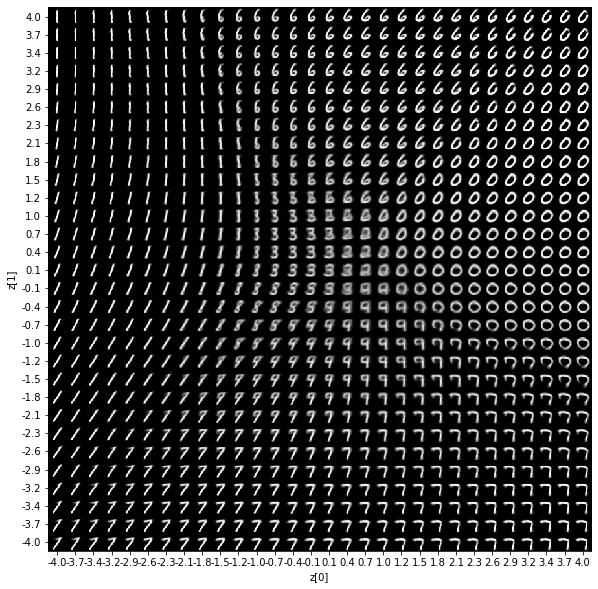

In [0]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi,yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
#plt.savefig(filename)
plt.show()

In [0]:
vae.fit(train_images[3001:6000],batch_size=1,epochs=3)

Epoch 1/3
2999/2999 [==============================] - 116s 39ms/step - loss: 165.3446
Epoch 2/3
2999/2999 [==============================] - 119s 40ms/step - loss: 163.5144
Epoch 3/3
2999/2999 [==============================] - 118s 39ms/step - loss: 162.1822
